# Deep Koopman
# John (Jack), Quinn
## Data Driven Modeling Presentation
This is the code portion for the Deep Koopman presentation.
See https://github.com/BethanyL/DeepKoopman for more code.

Originally this method was written with tensorflow, however most of the tensorflow used has been depricated. There are some implementations in pytorch which we will use. The best implementation is given here: https://github.com/GaloisInc/dlkoopman/tree/ed11bef92b90112d9ca90722942a6789e6af7d5a. 

In [17]:
#!conda install -c anaconda scipy
#!conda install pytorch 
import scipy.io as sio
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as Fun
from torch.autograd import Variable
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import time
start_time = time.time()
np.random.seed(seed=1)
torch.manual_seed(0)

In [16]:
#!pip install shortuuid
#!pip install tqdm
from pathlib import Path
import random
from typing import Any
from collections import defaultdict
from pathlib import Path
import shortuuid
from tqdm import tqdm

Useful packages.

### Data Generation
---
Here we will generate the data for the expirment. this is a simple implementation I wrote.

In [4]:
delT= 0.001
a=16
r=45
b=4
def Lorenz(x,t):
    xK=x[0]
    y=x[1]
    z=x[2]
    xDot= a*(y-xK)
    yDot= r*xK-y-xK*z
    zDot= xK*y-b*z
    return np.array((xDot,yDot,zDot))

In [7]:
def RungaKuta4(t0,h,n,x,f,auto=False):
    if auto:
        k1=f(x,t0) 
        k2=f(x+(h/2)*k1,t0+(h/2))
        k3=f(x+(h/2)*k2,t0+(h/2))
        k4=f(x+(h)*k3,t0+(h))
        return x+(h/6)*(k1+2*k2+2*k3+k4)
    else:
        k1=f(x) 
        k2=f(x+(h/2)*k1)
        k3=f(x+(h/2)*k2)
        k4=f(x+(h)*k3)
        return x+(h/6)*(k1+2*k2+2*k3+k4)
    
    return
def rungaiter(n,delT,fun,start):
    itermax=n
    yvals=[]
    xvals=[]
    zvals=[]
    sX,sY,sZ = start
    start=np.array((sX,sY,sZ))
    yvals.append(sY)
    xvals.append(sX)
    zvals.append(sZ)
    out = start
    for i in range(itermax):
        out = RungaKuta4(t0=0,h=delT,n=0,x=out,f=fun,auto=True)
        x,y,z=out
        xvals.append(x)
        yvals.append(y)
        zvals.append(z)
    fig = plt.figure(figsize=(12,10))
    ax = plt.axes(projection='3d')
    ax.scatter3D(xvals,yvals,zvals,s=0.03,c='blue')
    plt.title("State Space Trajectory")
    plt.xlabel("x")
    plt.ylabel("y")
    ax.set_zlabel('z')
    return xvals,yvals,zvals

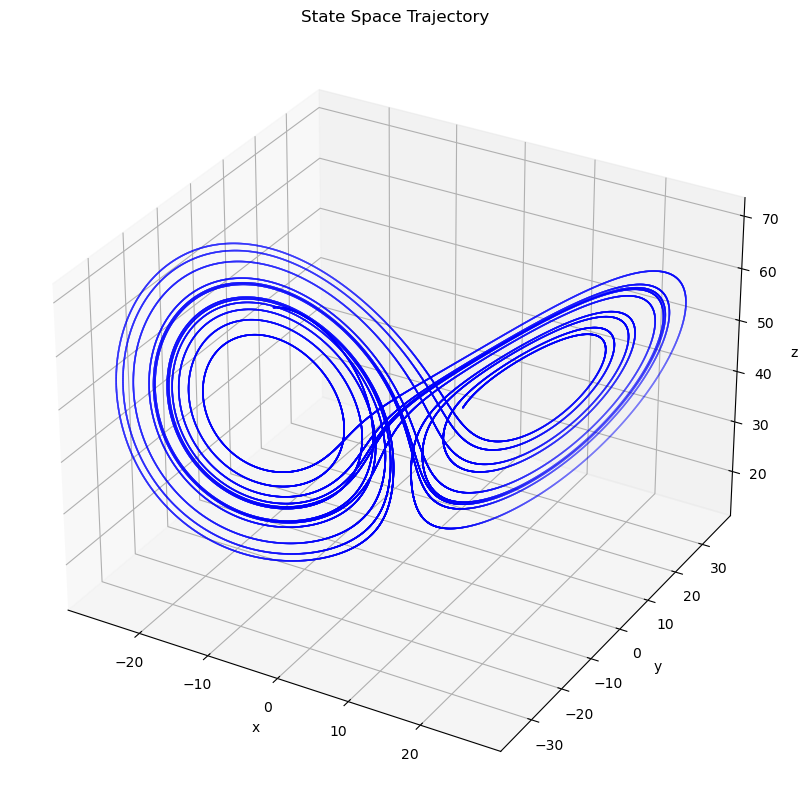

In [179]:
start=(-13,-12,62)
delt=0.0001
hold = rungaiter(100000,delt,Lorenz,start=start)
#plt.title("Trajectory")

In [124]:
Xtrn = np.array(hold).T
Xtrn_tens = torch.Tensor(Xtrn)

---

## Method
Here I implement the method using the code given in the above references.

---

### Architecture:

In [274]:
class MLP(torch.nn.Module):
    """Multi-layer perceptron neural net.
    """
    def __init__(self, input_size, output_size, hidden_sizes=[], batch_norm=False):
        """ """
        super().__init__()
        self.net = torch.nn.ModuleList([])
        layers = [input_size] + hidden_sizes + [output_size]
        for i in range(len(layers)-1):
            self.net.append(torch.nn.Linear(layers[i],layers[i+1]))
            if i != len(layers)-2: #all layers except last
                if batch_norm:
                    self.net.append(torch.nn.BatchNorm1d(layers[i+1]))
                self.net.append(torch.nn.ReLU())

    def forward(self, X): #-> torch.Tensor:
        """Forward propagation of neural net.
        """
        for layer in self.net:
            X = layer(X)
        return X


class AutoEncoder(torch.nn.Module):
    """AutoEncoder neural net. Contains an encoder connected to a decoder, both are multi-layer perceptrons.
    - **encoder** - Encoder neural net.
    - **decoder** - Decoder neural net.
    """
    def __init__(self, input_size, encoded_size, encoder_hidden_layers=[], 
                 decoder_hidden_layers=[], batch_norm=False):
        """ """
        super().__init__()

        if not decoder_hidden_layers and encoder_hidden_layers:
            decoder_hidden_layers = encoder_hidden_layers[::-1]
        elif not encoder_hidden_layers and decoder_hidden_layers:
            encoder_hidden_layers = decoder_hidden_layers[::-1]

        self.encoder = MLP(
            input_size = input_size,
            output_size = encoded_size,
            hidden_sizes = encoder_hidden_layers,
            batch_norm = batch_norm
        )

        self.decoder = MLP(
            input_size = encoded_size,
            output_size = input_size,
            hidden_sizes = decoder_hidden_layers,
            batch_norm = batch_norm
        )

    def forward(self, X):# 
        """Forward propagation of neural net.
        """
        Y = self.encoder(X) # encoder complete output
        Xr = self.decoder(Y) # final reconstructed output
        return Y, Xr


class Knet(torch.nn.Module):
    """Linear neural net to approximate the Koopman matrix.
    Contains identically sized input and output layers, 
    no hidden layers, no bias vector, and no activation function.
    """
    def __init__(self, size):
        """ """
        super().__init__()
        self.net = torch.nn.Linear(in_features=size, out_features=size, bias=False)

    def forward(self, X):# -> torch.Tensor:
        """Forward propagation of neural net.
        """
        return self.net(X)
class Knet_eig(torch.nn.Module):
    """Linear neural net to approximate the Koopman matrix.
    Contains identically sized input and output layers, 
    no hidden layers, no bias vector, and no activation function.
    """
    def __init__(self, size):
        """ """
        super().__init__()
        self.net = torch.nn.Linear(in_features=size, out_features=size, bias=False)

    def forward(self, X):# -> torch.Tensor:
        """Forward propagation of neural net.
        """
        return self.net(X)
def form_jordanblock(omegas,delt):
    #Lambdas, eigvecs=torch.linalg.eig(Kn.net.weight)
    mu=omegas[:,0]
    om=omegas[:,1]
    L=torch.stack([torch.stack([torch.exp(mu*delt)*torch.cos(om*delt),-torch.exp(mu*delt)*torch.sin(om*delt)]),
                 torch.stack([torch.exp(mu*delt)*torch.sin(om*delt),torch.exp(mu*delt)*torch.cos(om*delt)])])
    return torch.transpose(L,0,1)
def varying_multiply(omegas,Y,num_comp,num_real,delt):
    out = torch.zeros(Y.size())
    for i in range(num_comp):
        L=form_jordanblock(omegas[:,2*i:2*i+2],delt)
        print(L.size())
        print(Y[:,2*i:2*i+2].size())
        out[:,2*i:2*i+2]=torch.matmul(L,Y[:,2*i:2*i+2])
    for i in range(num_real):
        #print(torch.exp(delt*omegas[:,2*num_comp+i]).size())
        #print(Y[:,2*num_comp+i].size())
        out[:,2*num_comp+i] = torch.exp(delt*omegas[:,2*num_comp+i])*Y[:,2*num_comp+i]
    return out

### Loss:

In [275]:
def overall_loss(X, Y, Xr, Ypred, Xpred, decoder_loss_weight=1):# 
    """Computes overall loss for a model.
    """
    losses = {
        'recon': torch.nn.MSELoss(reduction='mean')(X, Xr),
        'lin': torch.nn.MSELoss(reduction='mean')(Y, Ypred),
        'pred': torch.nn.MSELoss(reduction='mean')(X, Xpred)
    }
    losses_tot = losses['lin'] + decoder_loss_weight * (losses['recon'] + losses['pred'])
    return losses_tot

### Training

In [276]:
dim_of_dynam=3
latent_size=3
Hidden_layers=[32,64,32]
num_comp=0
num_real=3
ae = AutoEncoder(
            input_size = dim_of_dynam,
            encoded_size = latent_size,
            encoder_hidden_layers = Hidden_layers,
            decoder_hidden_layers = Hidden_layers,
            batch_norm = False)
Kn = Knet(size = latent_size)
params=list(ae.parameters()) + list(Kn.parameters())
opt = torch.optim.Adam(params, lr=0.01)

In [277]:
def training(XTrn,ae,Kn,numepochs=10,batch_size=100,eigen=False,num_comp=num_comp,num_real=num_real,delt=delt):
    loss_vec=[]
    for i in range(numepochs):
        permutation = torch.randperm(XTrn.size()[0])
        for j in range(0,XTrn.size()[0], batch_size):
            opt.zero_grad()
            indI=permutation[i:i+batch_size]
            x_in=XTrn[indI]
            Ytr, Xrtr = ae(x_in)
            if eigen:
                omegas = Kn(Ytr)
                Ypredtr = varying_multiply(omegas,Ytr,num_comp,num_real,delt)
            else:
                Ypredtr = Kn(Ytr)
            #Ypredtr = Kn(Ytr) # shape = (batch_size, num_indexes, encoded_size)
            Xpredtr = ae.decoder(Ypredtr) # shape = (batch_size, num_indexes, input_size)
            # Compute the loss and its gradients
            loss = overall_loss(x_in, Ytr, Xrtr, Ypredtr, Xpredtr)
            loss.backward()
            opt.step()
        loss_vec.append(loss.item())
        if i%10==0:
            print("training at epoch:",i,"Loss:",loss_vec[-1])
    Lambdas, eigvecs = torch.linalg.eig(Kn.net.weight)
    return loss_vec,Lambdas,eigvecs

In [278]:
loss_vec,eig,eigvs=training(Xtrn_tens,ae,Kn,numepochs=100,batch_size=100,eigen=True)

training at epoch: 0 Loss: 1.4060267210006714
training at epoch: 10 Loss: 0.9805825352668762
training at epoch: 20 Loss: 0.003442053683102131
training at epoch: 30 Loss: 0.0074805011972785
training at epoch: 40 Loss: 0.0030216334853321314
training at epoch: 50 Loss: 0.0016315447865054011
training at epoch: 60 Loss: 0.0018913004314526916
training at epoch: 70 Loss: 0.033236730843782425
training at epoch: 80 Loss: 0.111468605697155
training at epoch: 90 Loss: 0.004254941828548908


Text(0, 0.5, 'Loss')

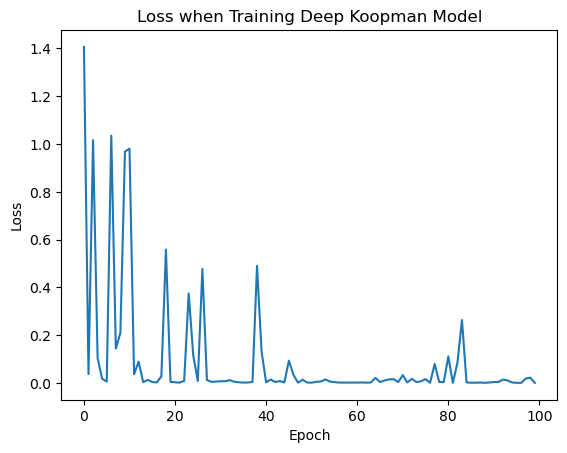

In [279]:
plt.plot(loss_vec)
plt.title("Loss when Training Deep Koopman Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [280]:
def predict_Deep_Koopman(X0,ae,Kn,len_of_pred=1000,eigen=False,num_comp=num_comp,num_real=num_real,delt=delt):
    pred=[X0.detach().numpy()]
    x=X0
    for i in range(len_of_pred):
        with torch.no_grad():
            y = ae.encoder(x)
            if eigen:
                omegas = Kn(y)
                Ypred = varying_multiply(omegas,y,num_comp,num_real,delt)
            else:
                Ypred = Kn(y)
            Xpred = ae.decoder(Ypred)
            pred.append(Xpred.detach().numpy())
            x=Xpred
    return pred

In [292]:
preds=predict_Deep_Koopman(torch.Tensor(np.array([start,start])),ae,Kn,len_of_pred=1000,eigen=True)
#print(np.array(preds).T)

Text(0.5, 0, 'z')

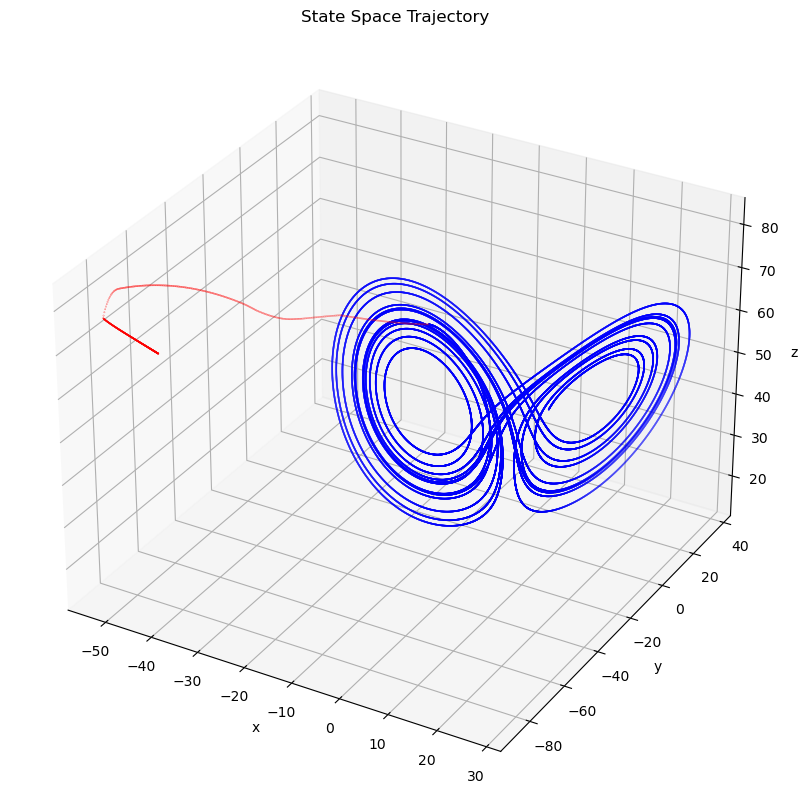

In [291]:
preds_to_show=np.array(preds).T
#hold = rungaiter(10000,0.001,Lorenz,start=start)
#plt.title("Trajectory")
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection='3d')
ax.scatter3D(hold[0],hold[1],hold[2],s=0.03,c='blue')
ax.scatter3D(preds_to_show[0][0],preds_to_show[1][0],preds_to_show[2][0],s=0.03,c='red')
plt.title("State Space Trajectory")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel('z')

---

### Eigen Values:

---

In [160]:
print(eig)

tensor([-0.8448+0.j,  1.0000+0.j,  0.9996+0.j,  1.0003+0.j],
       grad_fn=<LinalgEigBackward0>)
